In [ ]:
import data_generator
import trainer
import model

# Understanding a realisctic training pipeline

## Background: The Poisson Problem

The code implements a learning pipeline for solving the Poisson equation:
-Δu = f

where:
- f is the forcing term (input)
- u is the solution (output)
- Δ is the Laplacian operator

## Function Spaces for Forcing Terms

The experiment draws forcing terms f from three different function spaces, each with distinct characteristics:

1. **Gaussian Processes (GP)**:
   - Smooth, continuous functions characterized by a correlation structure
   - Generated using an RBF (Radial Basis Function) kernel
   - Tends to produce smooth, naturally-varying functions
   - Good for modeling physical phenomena that vary smoothly in space

2. **Piecewise Linear Functions (PL)**:
   - Functions composed of connected linear segments
   - Have discontinuous derivatives at breakpoints
   - Represent simpler, more geometric variations
   - Good for modeling systems with sharp transitions or regime changes

3. **Chebyshev Polynomials (CP)**:
   - Orthogonal polynomial basis functions
   - Can represent highly oscillatory behavior
   - More complex functional form than GP or PL
   - Good for modeling periodic or oscillatory phenomena

## Pipeline Structure

The code implements a complete experimental pipeline with several key components:

1. **Data Generation** (imported from separate module):
   ```python
   datasets = {
       'GP': gaussian_process_samples,
       'PL': piecewise_linear_samples,
       'CP': chebyshev_samples
   }
   ```

2. **Dataset Management**:
   - `PoissonDataset` class handles data organization and device placement
   - Converts numpy arrays to PyTorch tensors
   - Manages training/validation splits

3. **Model Training**:
   - Uses Fourier Neural Operator (FNO) architecture
   - Performs spectral convolutions in Fourier space
   - Includes early stopping and learning rate scheduling
   ```python
   model = trainer.train_model(
       model, train_dataset, run_name=f"{train_class}_base_training"
   )
   ```

4. **Transfer Learning Experiments**:
   - Zero-shot evaluation: Testing on different function spaces without retraining
   - Fine-tuning: Adapting pre-trained models to new function spaces
   ```python
   zero_shot_loss = trainer.evaluate(model, eval_loader)
   fine_tuned_model = trainer.fine_tune(model.clone(), fine_tune_dataset)
   ```

## Why This Matters

This experiment helps us understand:
1. How well neural operators generalize across different types of functions
2. The effectiveness of transfer learning in PDE solving
3. Which function spaces are "harder" to learn from or generalize to

The results often show that:
- Training on more complex spaces (CP) can lead to better generalization
- Similar spaces (GP and PL) transfer well to each other
- Fine-tuning can significantly improve performance on dissimilar spaces

## Key Implementation Details

1. **Early Stopping**:
   ```python
   if early_stopping(val_loss):
       print("Early stopping triggered")
       break
   ```
   Prevents overfitting by monitoring validation loss

2. **Best Model Tracking**:
   ```python
   if val_loss < best_val_loss:
       best_val_loss = val_loss
       best_model_state = model.state_dict()
   ```
   Saves the best performing model during training

3. **Performance Visualization**:
   - Creates heatmaps comparing zero-shot and fine-tuned performance
   - Helps identify patterns in cross-space generalization

## Practical Considerations

When using this code:
1. Adjust hyperparameters based on your specific needs:
   - `modes`: More modes = better expressivity but slower training
   - `width`: Network width affects capacity and training stability
   - `batch_size`: Affects training stability and memory usage

2. Monitor training curves for:
   - Convergence behavior
   - Potential overfitting
   - Learning rate adjustment needs

This implementation provides a framework for understanding how neural operators learn and transfer knowledge across different function spaces in the context of PDE solving.

# Data generation


Your task will be to test the generalization properties of neural solvers when exposed to training terms outside the training distribution. The following algorithm, which is already implemented in the `data_generator` file will serve as your source of data.

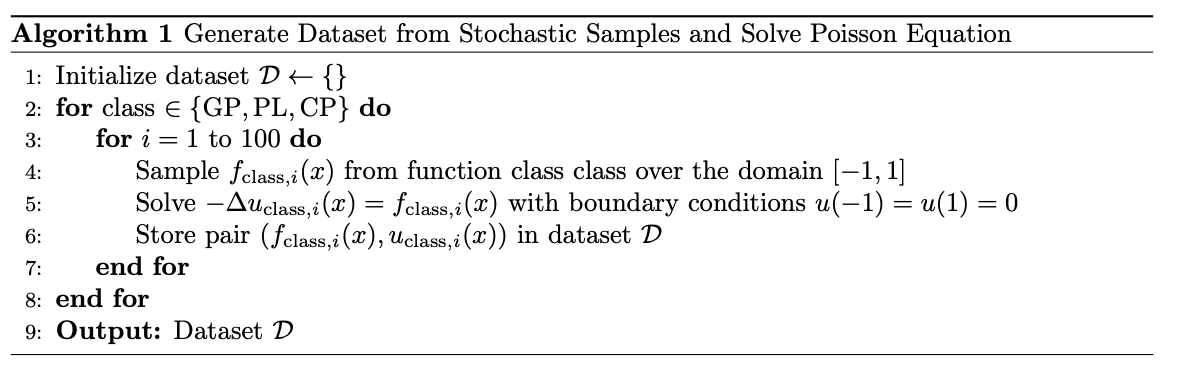

# Training



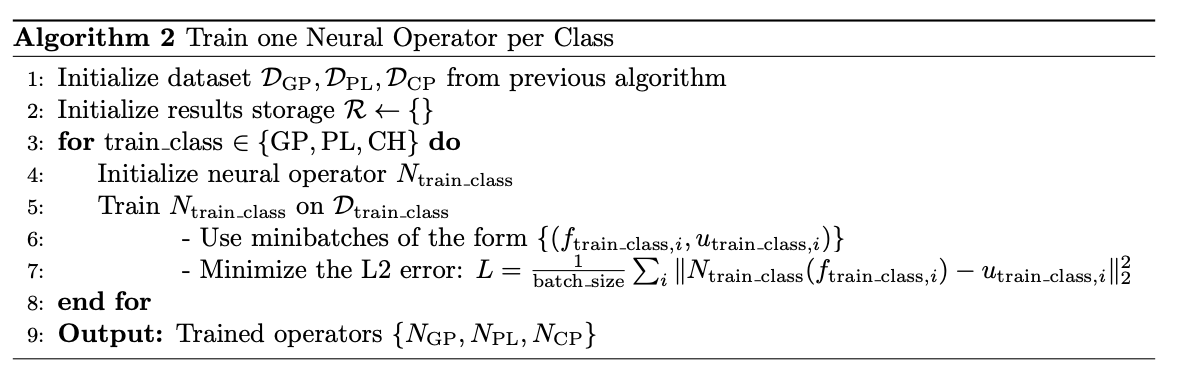

# Testing

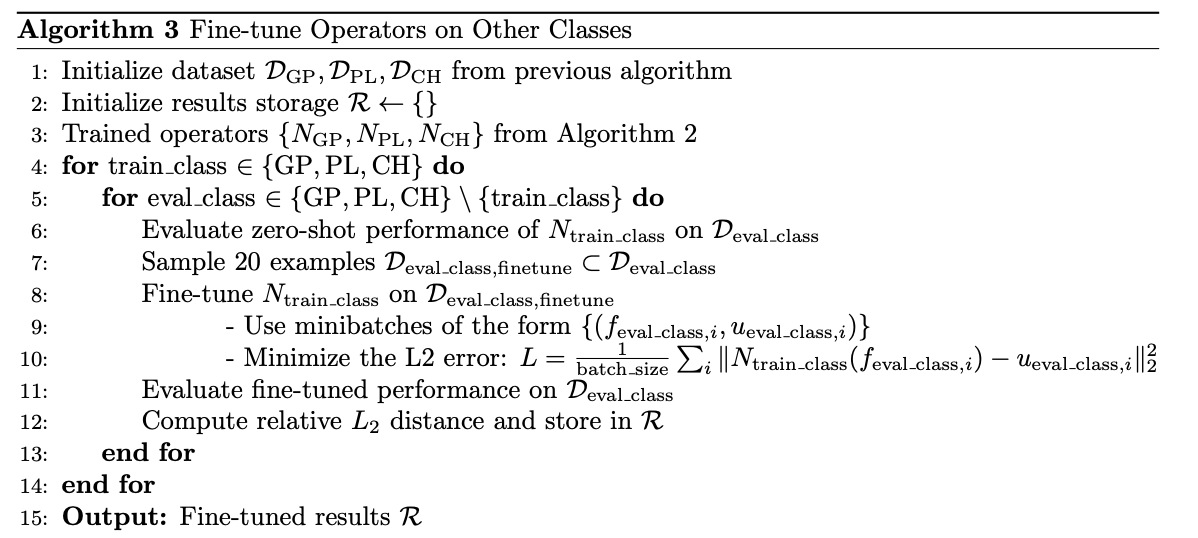

In [ ]:
# Setup configurations
domain_config = data_generator.DomainConfig(
    x_min=-1.0,
    x_max=1.0,
    n_points=128  # Reduced for faster computation
)

training_config = trainer.TrainingConfig(
    batch_size=32,
    learning_rate=1e-3,
    epochs=50,
    device="cuda" if torch.cuda.is_available() else "cpu",
    early_stopping_patience=5,
    fine_tuning_epochs=20,
    fine_tuning_lr=1e-4,
    modes=12,
    width=32
)

print("Generating datasets...")
generator = data_generator.DatasetGenerator(domain_config)
datasets = generator.generate_dataset(n_samples=50)  # This will generate GP, PL, and CP datasets

print("Starting experiment...")
print(f"Using device: {training_config.device}")
print(f"Dataset sizes:")
for class_name, data in datasets.items():
    print(f"{class_name}: {len(data)} samples")

# Run experiment
try:
    results, models = trainer.run_experiment(datasets, training_config)

    # Print summary
    print("\nExperiment Results Summary:")
    for train_class in results.keys():
        print(f"\nModel trained on {train_class}:")
        for eval_class in results[train_class].keys():
            zero_shot = results[train_class][eval_class]['zero_shot_loss']
            fine_tuned = results[train_class][eval_class]['fine_tuned_loss']
            print(f"  {eval_class} data:")
            print(f"    Zero-shot MSE: {zero_shot:.6f}")
            print(f"    Fine-tuned MSE: {fine_tuned:.6f}")
            print(f"    Improvement: {(1 - fine_tuned/zero_shot)*100:.2f}%")

    # Save models
    os.makedirs("models", exist_ok=True)
    for class_name, model in models.items():
        torch.save(model.state_dict(), f"models/fno_{class_name}.pt")

    print("\nExperiment completed successfully!")
    print("Results have been plotted to 'results/performance_comparison.png'")
    print("Models have been saved to the 'models' directory")

except Exception as e:
    print(f"An error occurred during the experiment: {str(e)}")
    raise

# Appendix A: Function Space Specifications

## A.1 Gaussian Process (GP) with RBF Kernel

Let $(\Omega, \mathcal{F}, \mathbb{P})$ be a probability space. A Gaussian process $f: \mathbb{R} \to L^2(\Omega)$ is characterized by the property that any finite collection $(f(x_1), ..., f(x_n))$ follows a multivariate normal distribution.

**Definition A.1.1** (Gaussian Process)
A GP is completely specified by its first two moments:
- Mean function: $m(x) = \mathbb{E}[f(x)]$
- Covariance function: $k(x,x') = \mathbb{E}[(f(x) - m(x))(f(x') - m(x'))]$

For our implementation, we use the radial basis function (RBF) kernel:

**Definition A.1.2** (RBF Kernel)
$k(x,x') = \sigma_f^2 \exp\left(-\frac{\|x-x'\|^2}{2l^2}\right)$

where $\sigma_f^2$ is the signal variance and $l$ is the characteristic length scale.

For discretized sampling, let $\mathbf{x} = (x_1,\ldots,x_n)$ be a finite set of points. Then:
$f(\mathbf{x}) \sim \mathcal{N}(\mathbf{m}, K)$
where $K_{ij} = k(x_i,x_j)$ is the Gram matrix.

## A.2 Piecewise Linear Functions (PL)

**Definition A.2.1** (Piecewise Linear Function)
Let $[a,b]$ be a closed interval and $\{x_0,x_1,\ldots,x_k\}$ be a partition where $a=x_0 < x_1 < \cdots < x_k=b$. A piecewise linear function $f:[a,b]\to\mathbb{R}$ is defined as:

$f(x) = \begin{cases}
\alpha_1x + \beta_1 & x \in [x_0,x_1] \\
\alpha_2x + \beta_2 & x \in [x_1,x_2] \\
\vdots & \vdots \\
\alpha_kx + \beta_k & x \in [x_{k-1},x_k]
\end{cases}$

where $\alpha_i,\beta_i \in \mathbb{R}$ and continuity is enforced at breakpoints:
$\alpha_ix_i + \beta_i = \alpha_{i+1}x_i + \beta_{i+1}$ for $i=1,\ldots,k-1$

## A.3 Chebyshev Polynomials (CP)

**Definition A.3.1** (Chebyshev Polynomials)
The Chebyshev polynomials $\{T_n(x)\}_{n=0}^\infty$ form an orthogonal basis with respect to the weight function $w(x)=\frac{1}{\sqrt{1-x^2}}$ on $[-1,1]$. They satisfy:

1. Initial conditions:
   - $T_0(x) = 1$
   - $T_1(x) = x$

2. Recurrence relation:
   - $T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x)$ for $n \geq 1$

**Definition A.3.2** (Random Chebyshev Series)
A random function in the Chebyshev space is defined as:

$f(x) = \sum_{i=0}^{N-1} c_iT_i(x)$

where $c_i$ are i.i.d. random variables, typically chosen as $c_i \sim \mathcal{N}(0,\sigma_i^2)$ with $\sigma_i^2$ decreasing with $i$ to ensure smoothness.

**Properties:**
1. $T_n(\cos\theta) = \cos(n\theta)$
2. $\|T_n\|_{L^2_w[-1,1]} = \begin{cases}\pi & n=0 \\ \pi/2 & n>0\end{cases}$
3. The polynomials satisfy the discrete orthogonality relation on Chebyshev nodes.

This construction provides a rich space of functions suitable for testing operator learning algorithms, with increasing complexity from PL to GP to CP in terms of their functional expressivity.